<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/transfer_learning_tensor_flow_1_feature_extration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with Tensor flow Part 1: Feature extration

Transfer learning is leveraging a working model's existing architecture and leanrnin patterns for our own problems.

There are two main benefits:

1. Can leverage an existing neural network rproven to work on problems similar to our own.
2. Can leveareg a neural network architecture which has already learned patterns on similardat to our own, then we can adapt those patterns to our own data.

[Image net](https://image-net.org/index)

In [ ]:
!nvidia-smi

Mon May 20 01:49:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Download and become one with the data

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-05-20 10:59:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.207, 74.125.202.207, 74.125.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  69.9MB/s    in 2.3s    

2024-05-20 10:59:59 (69.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# Get data (10% of 10 food classes from Food101)

import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the `ImangeDataGenerator` class to load in our images in batches.

In [3]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [5]:
print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print('Testing images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionally you can add to your model to be performed during or after training. Some of the most popular callbacks:

* Tracking experiment with the tensro board callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains to long and overfits) with the EarlyStopping callback

In [6]:
# Create tensorboard callback (functionezed because we need to crate a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating a model using tensorflow hub

IN the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can acces pretrained model on: [texto do link](https://tfhub.dev)

Browsing teh TensorFlow Hub page and sorting for image classification, we found the following feature vector mdoel link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

[Tensorflow hub](https://www.tensorflow.org/hub?hl=pt-br)

In [7]:
# Let's compare teh following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [10]:
# Let's make a create model function to create a model from url
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to the number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs neurons.
  """
  #Fownload the pretatined model and save as keras layer

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax")
    ])

  return model

### Creating ResNet TensroFlow Hub Feature Extarction model

In [11]:
# Create Resnet model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [13]:
# Compile the resnet model

resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [14]:
# Let's fit or ResNet model to the data  (10 percent of 101 model)
resnet_history = resnet_model.fit(train_data,
                                  epochs=EPOCHS,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                          experiment_name="resnet50V2")]
                                  )


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240520-110058
Epoch 1/5
24/24 [==============================] - 45s 2s/step - loss: 2.0133 - accuracy: 0.3333 - val_loss: 1.2154 - val_accuracy: 0.6192
Epoch 2/5
24/24 [==============================] - 40s 2s/step - loss: 0.9362 - accuracy: 0.7000 - val_loss: 0.8898 - val_accuracy: 0.7084
Epoch 3/5
24/24 [==============================] - 40s 2s/step - loss: 0.6393 - accuracy: 0.8080 - val_loss: 0.7660 - val_accuracy: 0.7532
Epoch 4/5
24/24 [==============================] - 40s 2s/step - loss: 0.4895 - accuracy: 0.8680 - val_loss: 0.7216 - val_accuracy: 0.7616
Epoch 5/5
24/24 [==============================] - 39s 2s/step - loss: 0.3958 - accuracy: 0.9040 - val_loss: 0.6975 - val_accuracy: 0.7736


In [15]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()


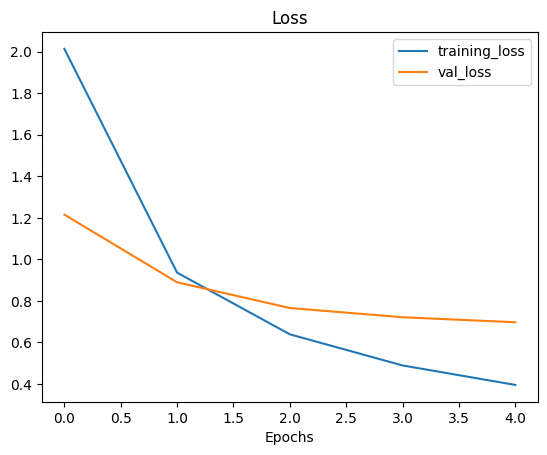

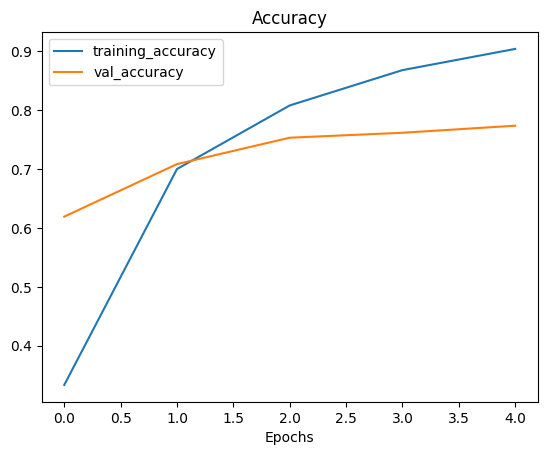

In [16]:
plot_loss_curves(resnet_history)

Wow!

That. Is. Imcredible. Our transfer learning feature extraction model out performed ALL of the previous models we built by hand... (substantially) and in a quicker trainig time AND only 10% of the training examples.

In [17]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [19]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data.num_classes)

In [20]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [21]:
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [22]:
efficientnet_model_history = efficientnet_model.fit(train_data,
                                  epochs=EPOCHS,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                          experiment_name="efficientnetb0")]
                                  )

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20240520-113634
Epoch 1/5
24/24 [==============================] - 41s 1s/step - loss: 1.8219 - accuracy: 0.4667 - val_loss: 1.2586 - val_accuracy: 0.7456
Epoch 2/5
24/24 [==============================] - 32s 1s/step - loss: 1.0355 - accuracy: 0.7840 - val_loss: 0.8347 - val_accuracy: 0.8348
Epoch 3/5
24/24 [==============================] - 33s 1s/step - loss: 0.7393 - accuracy: 0.8307 - val_loss: 0.6727 - val_accuracy: 0.8552
Epoch 4/5
24/24 [==============================] - 31s 1s/step - loss: 0.5945 - accuracy: 0.8693 - val_loss: 0.5922 - val_accuracy: 0.8612
Epoch 5/5
24/24 [==============================] - 32s 1s/step - loss: 0.5021 - accuracy: 0.8973 - val_loss: 0.5440 - val_accuracy: 0.8596


In [ ]:
efficientnet_model.evaluate(test_data)

79/79 [==============================] - 9s 108ms/step - loss: 0.5549 - accuracy: 0.8548


[0.5548538565635681, 0.8547999858856201]

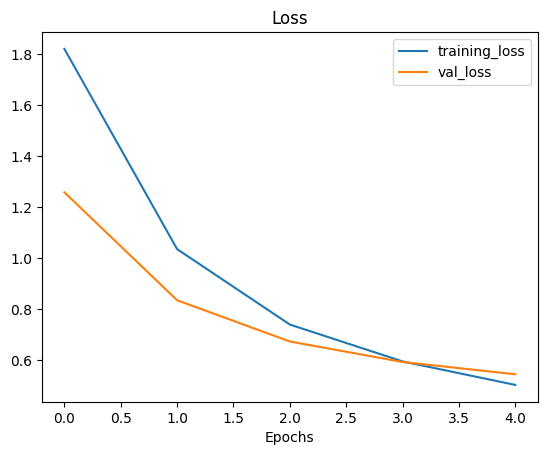

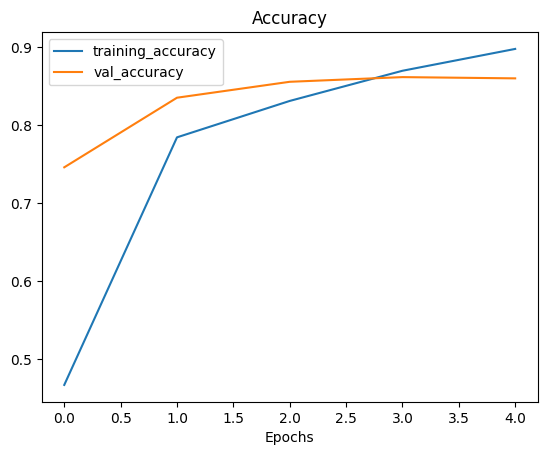

In [23]:
plot_loss_curves(efficientnet_model_history)